In [1]:
import pandas as pd
import numpy as np
import matplotlib
import json
from pandas import json_normalize
from IPython.display import display
import re

### Loading the data

In [2]:
data = pd.read_csv('../../data/healthtap_full_processed.csv')

In [3]:
data = data.drop(columns=['Unnamed: 0'])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2287925 entries, 0 to 2287924
Data columns (total 8 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   doctor_name        object
 1   doctor_profession  object
 2   short_answer       object
 3   answer             object
 4   main_category      object
 5   question           object
 6   related_topics     object
 7   sub_category       object
dtypes: object(8)
memory usage: 139.6+ MB


### Main category

In [5]:
data['main_category'].describe()

count     2287925
unique        227
top         drugs
freq       120024
Name: main_category, dtype: object

### Histogram of top categories (count more than 10 000)

<AxesSubplot:>

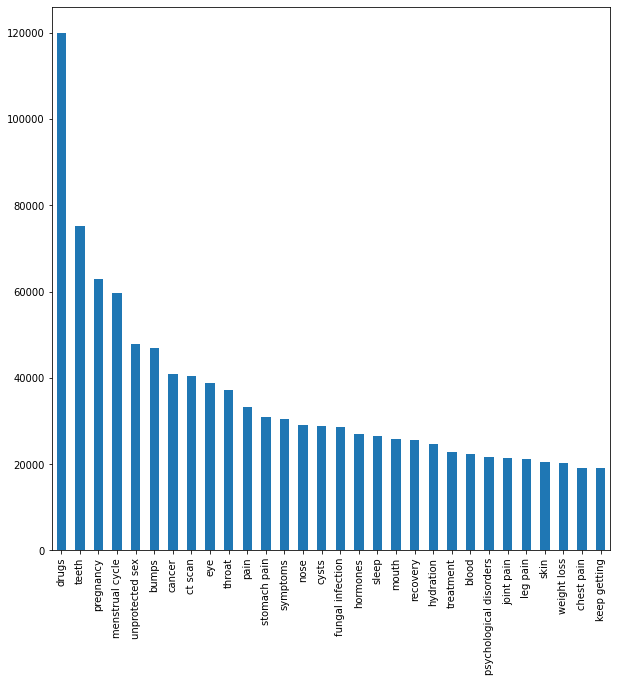

In [6]:
data['main_category'].value_counts().nlargest(30).plot(kind="bar", figsize=(10,10))

### Other columns

In [7]:
def clean_doctor(text):
    if (type(text) is float):
        return text
    
    text = re.sub('  Answered .*', '', text)
    
    return text

In [8]:
data['doctor_name'] = data.apply(lambda x: clean_doctor(x['doctor_name']), axis=1)

In [9]:
data['doctor_name'].describe()

count              2287925
unique               25889
top       Dr. Heidi Fowler
freq                 72068
Name: doctor_name, dtype: object

In [10]:
data.doctor_name.value_counts()

Dr. Heidi Fowler       72068
Dr. James Ferguson     28452
Dr. Ed Friedlander     24208
Dr. Robert Killian     24152
Dr. Jeff Livingston    21667
                       ...  
Dr Daniel Dorfman          1
Dr Wilbur Howard           1
Dr James Matera            1
Dr Lauren Gerson           1
Dr. Paula Young            1
Name: doctor_name, Length: 25889, dtype: int64

In [11]:
def clean_profession(text):
    if (type(text) is float):
        return text
    
    text = re.sub('^.* Answered .* 20[01]{1}[0-9]{1}  ', '', text)
    
    if (re.search('^.* Answered .* 20[01]{1}[0-9]{1}', text)):
        return 'unknown'
    
    if (re.search('^.* Respondida ', text)):
        return 'unknown'
    
    return text

In [12]:
data['doctor_profession'] = data.apply(lambda x: clean_profession(x['doctor_profession']), axis=1)

In [13]:
data['doctor_profession'].describe()

count             2283931
unique                147
top       Family Medicine
freq               233594
Name: doctor_profession, dtype: object

In [14]:
data.doctor_profession.value_counts()

Family Medicine                  233594
Internal Medicine                176710
Pediatrics                       169205
Psychiatry                       150722
Obstetrics & Gynecology          132882
                                  ...  
Gastroenterology & Hepatology         1
General Surgery                       1
Paediatrics                           1
Transfusion Medicine                  1
Respiratory Medicine                  1
Name: doctor_profession, Length: 147, dtype: int64

<AxesSubplot:>

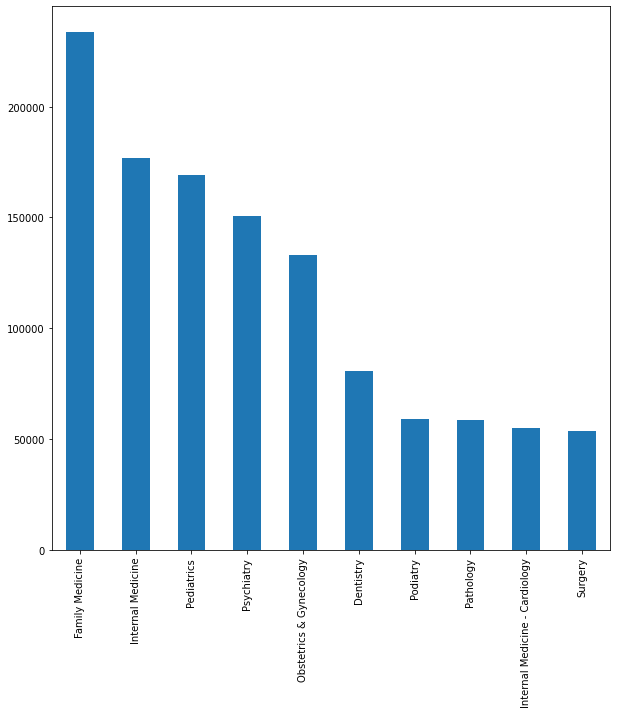

In [15]:
data['doctor_profession'].value_counts().nlargest(10).plot(kind="bar", figsize=(10,10))

In [16]:
data['sub_category'].describe()

count                 2287925
unique                   5048
top       high blood pressure
freq                    12092
Name: sub_category, dtype: object

### Count number of words in questions and answers and assign it to new columns

In [17]:
data['question_len'] = data['question'].str.split().apply(len)
data['answer_len'] = data['answer'].str.split().apply(len)

In [18]:
pd.set_option('float_format', '{:f}'.format)
display(data['question_len'].describe())
display(data['answer_len'].describe())

count   2287925.000000
mean         18.562765
std           9.430023
min           1.000000
25%          10.000000
50%          17.000000
75%          26.000000
max          65.000000
Name: question_len, dtype: float64

count   2287925.000000
mean         40.386308
std          22.666927
min           1.000000
25%          22.000000
50%          39.000000
75%          58.000000
max        1819.000000
Name: answer_len, dtype: float64

In [19]:
question_quantile = data['question_len'].quantile(0.95)
answer_quantile = data['answer_len'].quantile(0.95)

data = data[data['question_len'] < question_quantile]
data = data[data['answer_len'] < answer_quantile]


### Question length diagram

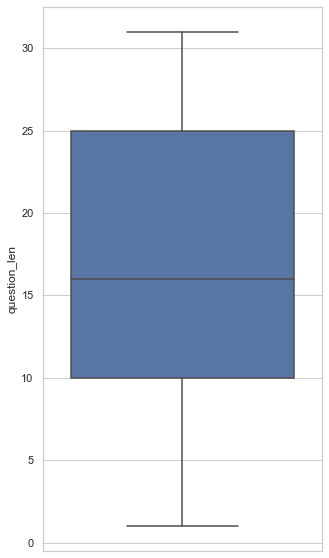

In [20]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt = sns.boxplot(y=data["question_len"])
plt.figure.set_size_inches(5,10)


<AxesSubplot:>

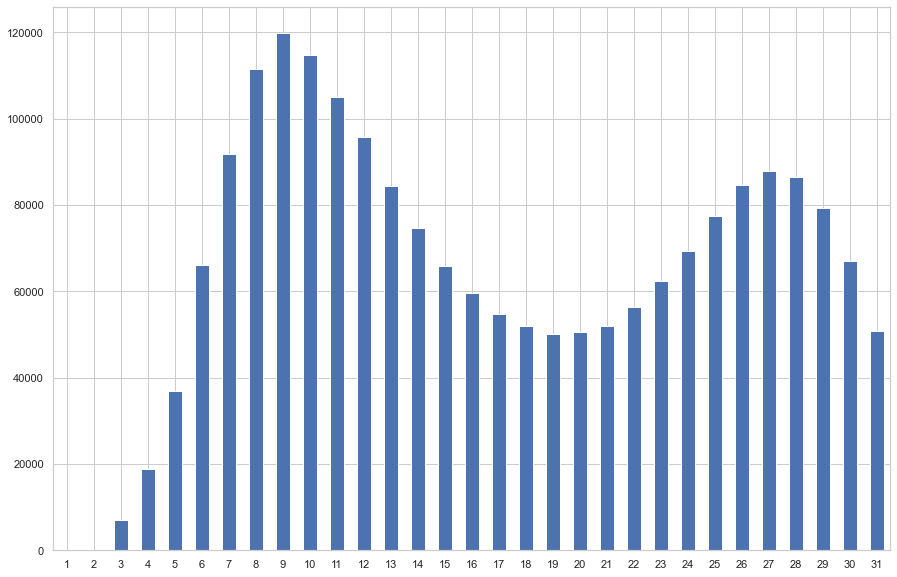

In [24]:
data['question_len_group'] = pd.cut(data['question_len'], bins=10, precision=0)
pd.value_counts(data['question_len']).sort_index().plot(kind="bar", figsize=(15,10), rot=0)

In [23]:
pd.value_counts(data['question_len']).sort_index()

1          1
2         13
3       7066
4      18940
5      36984
6      66175
7      91819
8     111499
9     119929
10    114741
11    105118
12     95707
13     84336
14     74620
15     65937
16     59660
17     54658
18     51866
19     50151
20     50482
21     51958
22     56411
23     62488
24     69392
25     77389
26     84515
27     87762
28     86555
29     79183
30     66909
31     50690
Name: question_len, dtype: int64

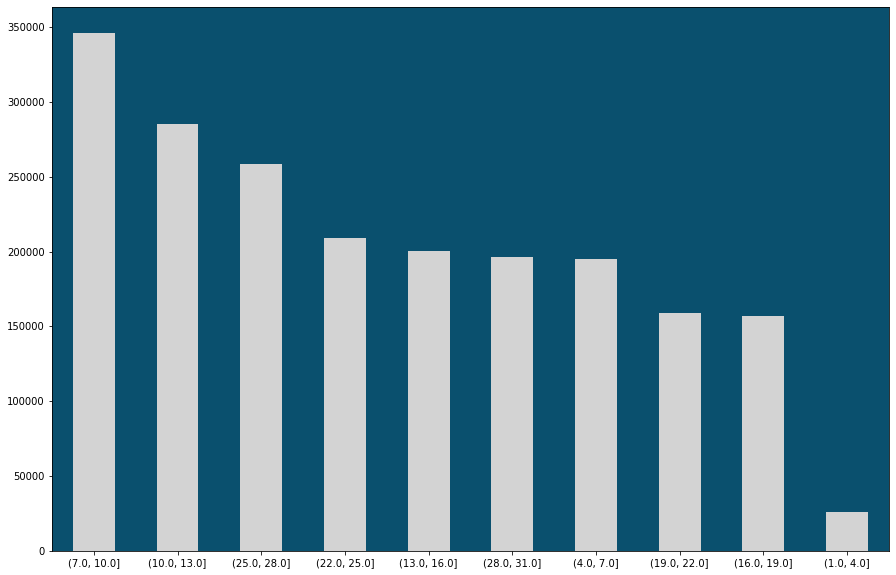

In [29]:
import matplotlib.pyplot as plt

ax = pd.value_counts(data['question_len_group']).plot(kind="bar", figsize=(15,10), rot=0, color="lightgray")
# Specify background color for the axis/plot
ax.xaxis.label.set_color('white')

ax.set_facecolor("#0A506E")


### Answer length diagram
We can observe that most answers have less than 100 words. We adjust the bin intervals according to this.

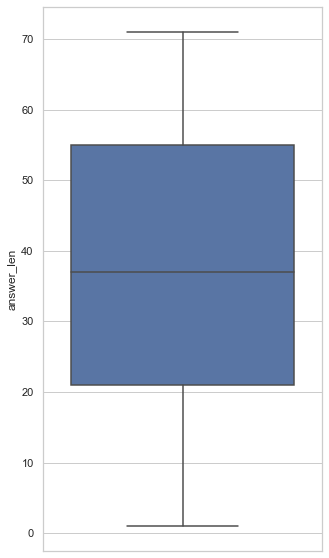

In [107]:
plt = sns.boxplot(y=data["answer_len"])
plt.figure.set_size_inches(5,10)

<AxesSubplot:>

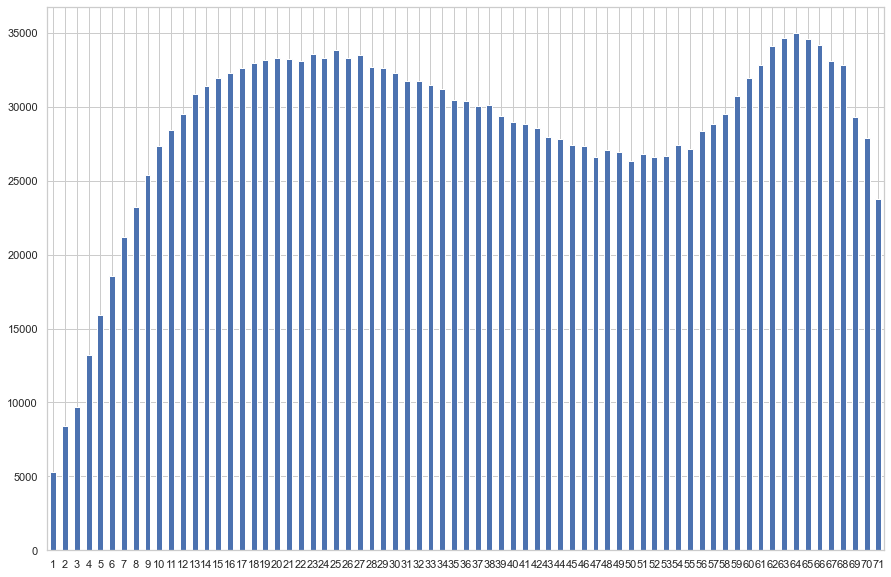

In [25]:
data['answer_len_group'] = pd.cut(data['answer_len'], bins=10, precision=0)
pd.value_counts(data['answer_len']).sort_index().plot(kind="bar", figsize=(15,10), rot=0)

In [15]:
len(data[data['answer_len'] > 100])

9611

<AxesSubplot:>

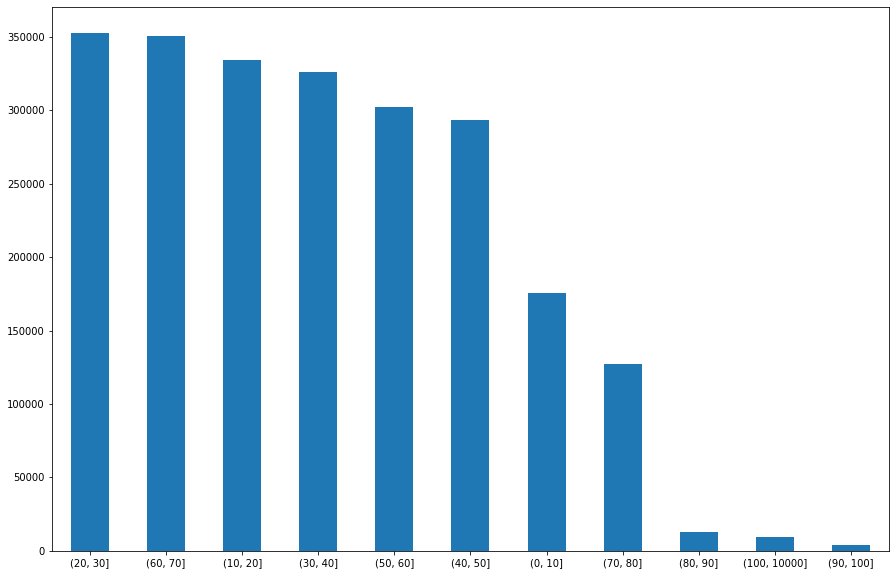

In [16]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 10000]
data['answer_len_group'] = pd.cut(data['answer_len'], bins=bins, precision=0)
pd.value_counts(data['answer_len_group']).plot(kind="bar", figsize=(15,10), rot=0)

### Word frequency in questions and answers

In [17]:
data.question.str.split(expand=True).stack().value_counts()[:50].plot(kind="bar", figsize=(15,10))

KeyboardInterrupt: 

In [ ]:
data.sample(n=10000).answer.str.split(expand=True).stack().value_counts()[:50].plot(kind="bar", figsize=(15,10))

In [18]:
pd.set_option('display.max_colwidth', None)
data.sample(n=50)[['question', 'answer']]

,question,answer
1860619,"Is over-the-counter glycolic acid cream, let's say 10%, as powerful as 0.05% Tretinoin for minor lines on face?","Comparing medicines. unfortunately it's not like comparing apples to apples. The concentrations of two different medicines don't always have the same effect. The vehicle or the purity may affect how ""strong"" it is. Tretinoin tends to be more effective but for mild rytids (wrinkles) the glycolic acid may work well."
2071665,Male 55 been on 325 aspirin daily for years for primary prevention. Want to reduce to 81 as I understand that is optimal dose. Is it safe to do so?,Discuss with MD? I think the key question is -have you had a coronary event? If so I would NOT decrease aspirin. data for PRIMARY prevention is a little less compelling. 81mg would be sufficient to achieve your goals with less risk of ulcer if you are dedicated to doing this without any personal history of event. Note that aspirin may have more compelling preventive effectiveness for colon cancer. Be well.
1110723,Is there any chance of pregnancy after IVF failure .... Or missing of periods could be side effect of the IVF ...,"But if it failed then you cannot be pregnant, it depends how many periods you have missed but this can be worked up."
2169799,Is it rare for a yeast infection to kill someone if they had it for a long time?,I know of no situation where a yeast infection led to the death of anyone.
249172,What is the treatment for chf?,"Treatment depends on what the cause of the CHF is. Could be surgical, could be medical. Systolic CHF is different from diastolic CHF and valvar stenosis CHF is different from valvar insufficiency chf. Virtually all kinds have diuretic as part of the treatment."
1229868,Does claritan make children hyper?,"It's unusual, but... It does happen. Typically, non-sedating antihistamines are well tolerated by children, and the more common side effect is modest sedation. That being said, I have cared for a few kids through the years who have had atypical responses to claritin-like medications. I wonder if tour child has the same response to Diphenhydramine (aka, benadryl)."
2173871,Had a volvulus in colon and had more than 8inches removed in emer surg 2yrs ago continue to have pain and discomfort same area?Can it happen again? Am i more at risk b/c i already had this once?,"Had a cecal volvulus, correct? If so, recurrence is unlikely, b/c surgeon prob did ileocecectomy. Pain in the area is no unusual, but you should get ct scan just to make sure there is no adhesive obstruction, especially closed loop obstruction, in the area. You need to see a GI surgeon if pain persists."
1226686,"My grandma has a mouth sore inside her cheeks, it is round & pinkish white in color, shes taking up anti fungal meds and cream and it doesn't work.",Have this examined and diagnosed and treated appropriately. Without seeing it there is no way a doctor could guess at this.
2160035,What are some things I can do to prevent yeast infections I seem to get them a lot?,"Probiotics contain good bacteria that helps keep vaginal pH in balance. Lactobacilli is a type of probiotic which has been shown to be helpful in reducing yeast infections. You can use a commercially available probiotic brand with 10-20 billion live cultures. Daily intake of garlic may also be helpful. For more tips, please refer to my health guide: vaginal health. Hope this helps!"
686508,"I have tmj, ehlers danlos and i'm pregnant. Something is catching in thefront right sidefof my neck when i chew. Slight pain from ear down neck. Help?",Please consult a dental surgeon to fix your TMJ subluxation.


In [ ]:
data[data.main_category == 'vagina'][['question', 'answer']]

In [ ]:
len(data[(data.answer_len < 30) & (data.question_len < 30)])

In [ ]:
short_data = data[(data.answer_len < 30) & (data.question_len < 30)]
short_data = short_data.drop(columns=['question_len', 'answer_len', 'question_len_group', 'answer_len_group', 'doctor_name', 'doctor_profession'])
short_data_sample = short_data.sample(n=100000)
short_data_sample.to_csv('../../data/healthtap_short_sample.csv')

In [ ]:
short_data.info()

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2287925 entries, 0 to 2287924
Data columns (total 12 columns):
 #   Column              Dtype   
---  ------              -----   
 0   doctor_name         object  
 1   doctor_profession   object  
 2   short_answer        object  
 3   answer              object  
 4   main_category       object  
 5   question            object  
 6   related_topics      object  
 7   sub_category        object  
 8   question_len        int64   
 9   answer_len          int64   
 10  question_len_group  category
 11  answer_len_group    category
dtypes: category(2), int64(2), object(8)
memory usage: 178.9+ MB


In [22]:
qa_data_all = data[['question', 'answer']]
qa_data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2287925 entries, 0 to 2287924
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   question  object
 1   answer    object
dtypes: object(2)
memory usage: 34.9+ MB


In [23]:
qa_data_all.to_csv('../../data/healthatp_qa_all.csv')

In [25]:
qa_data_30 = data
qa_data_30 = qa_data_30[(qa_data_30.answer_len < 30) & (qa_data_30.question_len < 30)]
qa_data_30 = qa_data_30[['question', 'answer']]
qa_data_30.to_csv('../../data/healthatp_qa_30.csv')

In [28]:
qa_data_30.sample(n=50).head(50)

,question,answer
240541,I have to many small scars that are caused due to nail. I have also brownish dots on my cheek from childhood. How to get rid from these?,"Pigmentation. try Aveeno (oatmeal) Clear Complexion cream for a month, It may help, Avoid sun light, uses a sun screen if you live in sunny area."
2225730,Are there other diseases like behcet's?,"Yes. Behcet's is sometimes considered as a form of vasculitis, but shares symptoms with collagen vascular disease."
2128037,Pressure eye pains headache dizziness. Eye dr. Found nothing antibiotics didn't help nasonex didn't help. What's going on? Eyelids don't stay closed,MD. Hard to say from here. Best to see your MD for evaluation.
218951,All of sudden my poop turned to a light gray color but when i wiped it was dark green. I have no other symptoms fever/pain. Should i be concerned?,"These are generally normal variations, especially in the absence of other symptoms. If you have chronic diarrhea have the issue evaluated."
432599,What should I do in wrist sprain?,"Sprain . Elevation, ice , anti inflammatory and protective brace. Must be sure that there is not a fracture as source i'd pain."
630803,Why is my period skipping every other month?,Not normal. You should discuss this with your dr. Could be hormonal causes such as thyroid disease or pcos. Ask your dr to do homone testing.
123670,Can you tell me how is physostigmine synthesized?,By Methylation of Tryptamine.
1319163,What is the normal range for blood pressure in a child 10-11 years old?,"Somewhere around 100-110/60-70. With increasing weights in children, we're seeing those numbers creep up a bit though."
1944691,What is the difference between colonscopy and abdomen ultra sound?,"Colonoscopy sees the inside of your colon, an us shows the architecture of the organs (usually the solid organs) from its surface."
556965,Hi .My dad is not able to bent his leg properly complaints and feels his leg warm internally.,This is an emergency and he needs to be seen at the hospital urgently.


In [32]:
qa_data_10 = data[(data.answer_len < 20) & (data.question_len < 20)]

In [33]:
qa_data_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289229 entries, 9 to 2287916
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   doctor_name         289229 non-null  object  
 1   doctor_profession   288838 non-null  object  
 2   short_answer        153069 non-null  object  
 3   answer              289229 non-null  object  
 4   main_category       289229 non-null  object  
 5   question            289229 non-null  object  
 6   related_topics      280740 non-null  object  
 7   sub_category        289229 non-null  object  
 8   question_len        289229 non-null  int64   
 9   answer_len          289229 non-null  int64   
 10  question_len_group  289229 non-null  category
 11  answer_len_group    289229 non-null  category
dtypes: category(2), int64(2), object(8)
memory usage: 24.8+ MB


In [34]:
qa_data_10.to_csv('../../data/healthtap_qa_20.csv')

In [35]:
qa_data_10 = qa_data_10[['question', 'answer']]

In [38]:
qa_data_10.to_csv('../../data/healthtap_qa_20.csv')